In [1]:
from typing import List, Dict
import tiktoken
import json
import pandas as pd

def get_context_length(entry: Dict, encoding_name: str = "cl100k_base") -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(entry["context_str"]))
    return num_tokens


def get_source_types(entry: Dict) -> List[str]:
    context = entry["context"]
    source_types = [x["index"] for x in context]
    return source_types


def get_df_stats(model_name: str, config_str: str):

    data_file = f"../data/results/{config_str}/all_dependencies_all_{model_name}.json"
    baseline_file = "../data/results/all_dependencies.csv"

    with open(data_file, "r", encoding="utf-8") as src:
        data = json.load(src)

    df = pd.read_csv(baseline_file)

    response_rating = []
    classification = []
    rationale = []
    plan = []
    uncertainty = []
    context_length = []
    source_types = []
    skipped = 0
    
    for entry, (index, row) in zip(data, df.iterrows()):

        assert entry["index"] == index
        
        response_dict = None
        isDependency = None

        context_length.append(get_context_length(entry=entry))
        source_types.append(get_source_types(entry=entry))

        try:
            if "responses" in entry:
                response = entry["responses"][0]
            else:
                response = entry["response"]
            response_dict = json.loads(response, strict=False)
            isDependency = response_dict["isDependency"]
            plan_str = response_dict["plan"]
            rationale_str = response_dict["rationale"]
            uncertainty_str = response_dict["uncertainty"]
        except (json.JSONDecodeError, KeyError):
            response_rating.append("None")
            classification.append("None")
            plan.append("None")
            rationale.append("None")
            uncertainty.append("None")
            skipped += 1
            continue

        rating = row["final_rating"]
        
        if str(rating).lower() == "borderline":
            if isDependency:
                response_rating.append(str(isDependency))
                classification.append("TP")
                plan.append(plan_str)
                rationale.append(rationale_str)
                uncertainty.append(uncertainty_str)
            if not isDependency:
                response_rating.append(str(isDependency))
                classification.append("TN")
                plan.append(plan_str)
                rationale.append(rationale_str)
                uncertainty.append(uncertainty_str)

        # FP: The LLM validates a dependency as correct, but the dependency is actually incorrect
        if isDependency and str(rating).lower() == "false":
            response_rating.append(str(isDependency))
            classification.append("FP")
            plan.append(plan_str)
            rationale.append(rationale_str)
            uncertainty.append(uncertainty_str)


        # FN: The LLM validates a dependency as incorrect, but the dependency is actually correct
        if not isDependency and  str(rating).lower() == "true":
            response_rating.append(str(isDependency))
            classification.append("FN")
            plan.append(plan_str)
            rationale.append(rationale_str)
            uncertainty.append(uncertainty_str)

        # TP: The LLM validates a dependency as correct and the dependency is correct
        if isDependency and str(rating).lower() == "true":
            response_rating.append(str(isDependency))
            classification.append("TP")
            plan.append(plan_str)
            rationale.append(rationale_str)
            uncertainty.append(uncertainty_str)

        # TN: The LLM validates a dependency as incorrect and the dependency is incorrect
        if not isDependency and str(rating).lower() == "false":
            response_rating.append(str(isDependency))
            classification.append("TN")
            plan.append(plan_str)
            rationale.append(rationale_str)
            uncertainty.append(uncertainty_str)


    print(f"Skipped {skipped} entries in file {data_file}.")
    df[f"response_rating"] = response_rating
    df["classification"] = classification
    df["plan"] = plan
    df["rationale"] = rationale
    df["uncertainty"] = uncertainty
    df["context_length"] = context_length
    df["source_types"] = source_types

    return df

model_names = ["gpt-3.5-turbo-0125", "gpt-4o-2024-05-13", "llama3:8b", "llama3:70b"] # "llama3.1:70b"
config_str = "config4"

for name in model_names:
    df = get_df_stats(model_name=name, config_str=config_str)
    print(df.columns)
    df.to_csv(f"../data/analysis/{config_str}/{name}.csv", index=False)

Skipped 0 entries in file ../data/results/config4/all_dependencies_all_gpt-3.5-turbo-0125.json.
Index(['dependency_category', 'index', 'link_str', 'project', 'option_name',
       'option_value', 'option_type', 'option_file', 'option_technology',
       'dependent_option_name', 'dependent_option_value',
       'dependent_option_type', 'dependent_option_file',
       'dependent_option_technology', 'config_type', 'rating', 'final_rating',
       'final_category', 'sub_category', 'explanation', 'response_rating',
       'classification', 'plan', 'rationale', 'uncertainty', 'context_length',
       'source_types'],
      dtype='object')
Skipped 0 entries in file ../data/results/config4/all_dependencies_all_gpt-4o-2024-05-13.json.
Index(['dependency_category', 'index', 'link_str', 'project', 'option_name',
       'option_value', 'option_type', 'option_file', 'option_technology',
       'dependent_option_name', 'dependent_option_value',
       'dependent_option_type', 'dependent_option_file'

In [2]:
import pandas as pd

model_names = ['gpt-4o-2024-05-13', 'gpt-3.5-turbo-0125', 'llama3:70b', 'llama3:8b'] # 'llama3.1:70b'

df_base = pd.read_csv("../data/results/all_dependencies.csv")

for name in model_names:
    file_name = f"../data/analysis/{config_str}/{name}.csv"
    df_model = pd.read_csv(file_name)

    classification = df_model["classification"].to_list()

    df_base[f"{name}_classification"] = classification


df_base.to_csv(f"../data/analysis/{config_str}/all.csv", index=False)

print(len(df_base))


500


342
Counter({'Multi-Maven-Modules': 97, 'Libraries': 87, 'Version Numbers': 45, 'Others': 37, 'Datasource': 17, 'Independent Components': 17, 'Port': 15, 'Generic Names': 14, 'Boolean': 8, 'Integers': 5})
Counter({'Maven Dependency': 61, 'Project Inheritance': 59, 'POM Version': 19, 'Datasource': 17, 'Others': 16, 'Port': 15, 'Names': 13, 'Project Version': 12, 'Maven Properties': 11, 'Dependency Scope': 10, 'Different Dockerfiles': 10, 'Logging Level': 9, 'Library': 9, 'Packaging Format': 9, 'Maven Plugin': 9, 'Boolean': 8, 'Maven Plugins': 7, 'Project Aggregation': 7, 'Project Structure': 7, 'Different Services': 7, 'Number': 5, 'JAVA Version': 5, 'Module as Dependency': 4, 'Logging': 3, 'Health Monitoring': 2, 'Encoding': 2, 'URL Handling': 2, 'Eureka': 1, 'Commands': 1, 'Generic Names': 1, 'Networks': 1})


/tmp/ipykernel_74611/4266729031.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_failures['FP_FN_count'] = df_failures[model_columns].apply(lambda row: row.isin(['FP', 'FN']).sum(), axis=1)


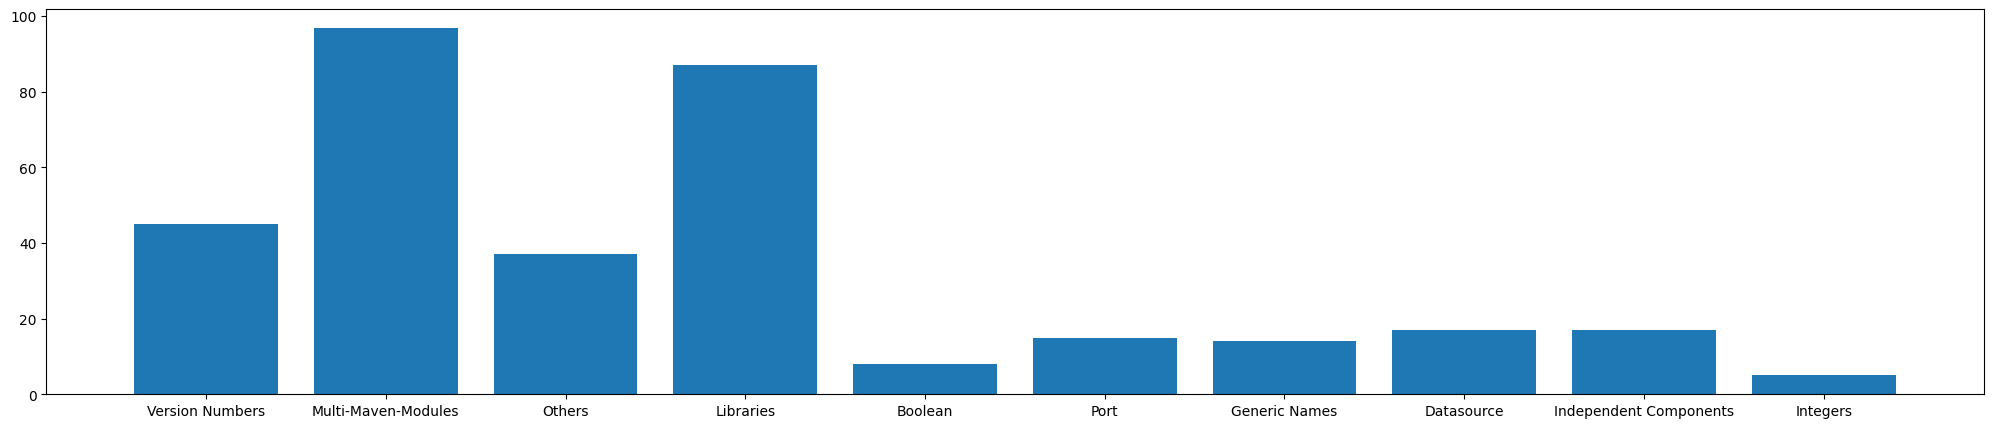

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

model_columns = ['gpt-4o-2024-05-13_classification', 'gpt-3.5-turbo-0125_classification', 'llama3:70b_classification', 'llama3:8b_classification']

failure_ids = set()


for name in model_names:
    file_name = f"../data/analysis/{config_str}/{name}.csv"
    df_model = pd.read_csv(file_name)

    for index, row in df_model.iterrows():
        if row["classification"] == "FP" or row["classification"] == "FN":
            failure_ids.add(index)


df_failures = df_base.iloc[list(failure_ids)]
df_failures['FP_FN_count'] = df_failures[model_columns].apply(lambda row: row.isin(['FP', 'FN']).sum(), axis=1)

print(len(df_failures))

df_failures.to_csv(f"../data/analysis/{config_str}/failures.csv", index=False)


categories = df_failures["final_category"].to_list()
sub_categories = df_failures["sub_category"].to_list()

category_counter = Counter(categories)
sub_category_counter = Counter(sub_categories)

print(category_counter)
print(sub_category_counter)

plt.figure(figsize=(25, 5)) 
plt.bar(category_counter.keys(), category_counter.values())
plt.show()

In [4]:
import pandas as pd

df = pd.read_csv(f"../data/analysis/{config_str}/all.csv")

# List of model columns to check
model_columns = ['gpt-4o-2024-05-13_classification', 'gpt-3.5-turbo-0125_classification', 'llama3:70b_classification', 'llama3:8b_classification'] # 'llama3.1:70b_classification'

# Create a boolean mask where True indicates the presence of 'FP' or 'FN' in any of the specified model columns
#mask = df[model_columns].apply(lambda x: x.isin(['FP', 'FN']), axis=1).any(axis=1)

# Filter the dataframe using the mask
#filtered_df_all = df[mask]

df['FP_FN_count'] = df[model_columns].apply(lambda row: row.isin(['FP', 'FN']).sum(), axis=1)
df['TP_TN_count'] = df[model_columns].apply(lambda row: row.isin(['TP', 'TN']).sum(), axis=1)

#sorted_df_all =  filtered_df_all.sort_values(by='FP_FN_count', ascending=False)

# Save the filtered dataframe if needed
df.to_csv(f'../data/analysis/{config_str}/all.csv', index=False)

In [5]:
import pandas as pd
from collections import Counter

df_all = pd.read_csv(f'../data/analysis/{config_str}/all.csv')

failure_count = df_all["FP_FN_count"].to_list()
success_count = df_all["TP_TN_count"].to_list()

failure_counter = Counter(failure_count)
success_counter = Counter(success_count)

print(len(df_all))

print("Failure counter: ", failure_counter)
print("Success counter: ", success_counter)

500
Failure counter:  Counter({0: 158, 1: 137, 2: 128, 3: 62, 4: 15})
Success counter:  Counter({3: 163, 2: 133, 4: 106, 1: 76, 0: 22})


In [6]:
import pandas as pd

df = pd.read_csv(f"../data/analysis/{config_str}/all.csv")

# List of model columns to check
model_columns = ['gpt-4o-2024-05-13_classification', 'gpt-3.5-turbo-0125_classification', 'llama3:70b_classification', 'llama3:8b_classification'] # 'llama3.1:70b_classification'

for column in model_columns:
    rating_counts = df[column].value_counts()

    print(column)
    print(rating_counts)
    print(sum(k for k in rating_counts.to_dict().values()))

gpt-4o-2024-05-13_classification
gpt-4o-2024-05-13_classification
TN    272
TP    112
FN     87
FP     29
Name: count, dtype: int64
500
gpt-3.5-turbo-0125_classification
gpt-3.5-turbo-0125_classification
TN    169
TP    143
FP    132
FN     56
Name: count, dtype: int64
500
llama3:70b_classification
llama3:70b_classification
TN    189
TP    145
FP    112
FN     54
Name: count, dtype: int64
500
llama3:8b_classification
llama3:8b_classification
FP    142
TP    130
TN     95
FN     27
Name: count, dtype: int64
394


In [7]:
import pandas as pd
from collections import Counter

baseline_file = "../data/results/all_dependencies.csv"

df = pd.read_csv(baseline_file)

categories = df["final_category"].to_list()

categories = [x.lower() for x in categories]

category_counter = Counter(categories)

category_counter

Counter({'multi-maven-modules': 143,
         'libraries': 114,
         'boolean': 57,
         'others': 49,
         'version numbers': 47,
         'generic names': 28,
         'independent components': 20,
         'datasource': 19,
         'port': 17,
         'integers': 6})

In [8]:
from typing import List
import pandas as pd

def get_category_stats(category_names: List, model_name: str):

    file_name = f"../data/analysis/{config_str}/{model_name}.csv"
    df = pd.read_csv(file_name)

    tp = []
    fp = []
    tn = []
    fn = []

    for category_name in category_names:

        df_category = df[df['final_category'].str.lower() == str(category_name)]

        #print(df_category["classification"].unique())

        rating_counts = df_category['classification'].value_counts().to_dict()

        #print(type(rating_counts))
        #print(df_category)
        #print(rating_counts)

        tp.append(rating_counts["TP"] if "TP" in rating_counts else "-")
        tn.append(rating_counts["TN"] if "TN" in rating_counts else "-" )
        fp.append(rating_counts["FP"] if "FP" in rating_counts else "-")
        fn.append(rating_counts["FN"] if "FN" in rating_counts else "-")

    
    data = {
        "category_name": category_names,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    }

    df = pd.DataFrame(data)

    print(df)

    #return df


model_names = ['gpt-4o-2024-05-13', 'gpt-3.5-turbo-0125', 'llama3:70b', 'llama3:8b', 'llama3.1:8b'] # 'llama3.1:70b'
category_names = list(category_counter.keys())

for model_name in model_names:
    print("Model: ", model_name)
    get_category_stats(category_names=category_names, model_name=model_name)


Model:  gpt-4o-2024-05-13
            category_name  TP  TN FP  FN
0         version numbers   6  13  9  19
1                 boolean   -  57  -   -
2     multi-maven-modules  72  25  5  41
3                  others   7  37  4   1
4               libraries  20  68  4  22
5                    port   5   9  3   -
6           generic names   -  26  2   -
7              datasource   2  13  -   4
8  independent components   -  19  1   -
9                integers   -   5  1   -
Model:  gpt-3.5-turbo-0125
            category_name  TP  TN  FP  FN
0         version numbers  20   6  16   5
1                 boolean   -  53   4   -
2     multi-maven-modules  76  16  14  37
3                  others   6  22  19   2
4               libraries  35  33  39   7
5                    port   3   1  11   2
6           generic names   -  20   8   -
7              datasource   3   6   7   3
8  independent components   -   8  12   -
9                integers   -   4   2   -
Model:  llama3:70b
            cat

**Which technologies are involved in dependencies that are incorrectly validated?**

In [9]:
from collections import Counter
import pandas as pd

model_names = ['gpt-4o-2024-05-13', 'gpt-3.5-turbo-0125', 'llama3:70b', 'llama3:8b'] # 'llama3.1:70b'

data = []

for model_name in model_names:
    print("Model: ", model_name)
    file_name = f"../data/analysis/{config_str}/{model_name}.csv"
    df_model = pd.read_csv(file_name)

    df_failures = df_model[df_model["classification"].isin(["FP", "FN"])]

    print("Failures: ", len(df_failures))

    technologies_failures = df_failures["option_technology"].to_list() 

    counter = Counter(technologies_failures)

    print("Technologies Failures: ", counter)


    model_data = {"model_name": model_name}
    model_data.update({k: v for k, v in counter.items()})
    data.append(model_data)


df = pd.DataFrame(data)
df


Model:  gpt-4o-2024-05-13
Failures:  116
Technologies Failures:  Counter({'maven': 99, 'spring': 7, 'docker-compose': 6, 'nodejs': 3, 'docker': 1})
Model:  gpt-3.5-turbo-0125
Failures:  188
Technologies Failures:  Counter({'maven': 115, 'spring': 31, 'docker-compose': 24, 'nodejs': 9, 'docker': 8, 'tsconfig': 1})
Model:  llama3:70b
Failures:  166
Technologies Failures:  Counter({'maven': 118, 'docker-compose': 19, 'spring': 15, 'nodejs': 7, 'docker': 6, 'tsconfig': 1})
Model:  llama3:8b
Failures:  169
Technologies Failures:  Counter({'maven': 104, 'spring': 26, 'docker-compose': 17, 'nodejs': 11, 'docker': 7, 'tsconfig': 4})


,model_name,maven,spring,docker,nodejs,docker-compose,tsconfig
0,gpt-4o-2024-05-13,99,7,1,3,6,NaN
1,gpt-3.5-turbo-0125,115,31,8,9,24,1.0
2,llama3:70b,118,15,6,7,19,1.0
3,llama3:8b,104,26,7,11,17,4.0


**Distribution of Intra- and Cross-Technogy Failures**

In [10]:
import pandas as pd

model_names = ['gpt-4o-2024-05-13', 'gpt-3.5-turbo-0125', 'llama3:70b', 'llama3:8b', 'llama3.1:8b'] # 'llama3.1:70b'


for model_name in model_names:
    intra = 0
    cross = 0
    print("Model: ", model_name)
    file_name = f"../data/analysis/{config_str}/{model_name}.csv"
    df_model = pd.read_csv(file_name)

    df_failures = df_model[df_model["classification"].isin(["FP", "FN"])]

    technologies_a = df_failures["option_technology"].to_list() 
    technologies_b = df_failures["dependent_option_technology"].to_list() 



    for x, y in zip(technologies_a, technologies_b):
        if x.lower() == y.lower():
            intra += 1
        else:
            cross += 1
    
    print("Num intra-technology failures: ", intra)
    print("Num cross-technology failures: ", cross)


Model:  gpt-4o-2024-05-13
Num intra-technology failures:  116
Num cross-technology failures:  0
Model:  gpt-3.5-turbo-0125
Num intra-technology failures:  181
Num cross-technology failures:  7
Model:  llama3:70b
Num intra-technology failures:  161
Num cross-technology failures:  5
Model:  llama3:8b
Num intra-technology failures:  160
Num cross-technology failures:  9
Model:  llama3.1:8b
Num intra-technology failures:  172
Num cross-technology failures:  8


**Context length of correctly and incorrectly classified dependencies**

In [11]:
import pandas as pd

model_names = ['gpt-4o-2024-05-13', 'gpt-3.5-turbo-0125', 'llama3:70b', 'llama3:8b', 'llama3.1:8b'] # 'llama3.1:70b'
config_str = "config1"



for model_name in model_names:
    print("Model: ", model_name)
    file_name = f"../data/analysis/{config_str}/{model_name}.csv"
    
    df_model = pd.read_csv(file_name)
    df_false = df_model[df_model["classification"].isin(["FP", "FN"])]
    df_true = df_model[df_model["classification"].isin(["TP", "TN"])]

    context_length_false = df_false["context_length"].to_list()
    context_length_true = df_true["context_length"].to_list()

    context_length_false_avg = round(int(sum([x for x in context_length_false]))/len(context_length_false),2)
    context_length_true_avg = round(int(sum([x for x in context_length_true]))/len(context_length_true),2)

    data.append({
        "model_name": model_name,
        "context_length_false": context_length_false_avg,
        "context_length_true": context_length_true_avg
    })
    

df = pd.DataFrame(data)
df

Model:  gpt-4o-2024-05-13
Model:  gpt-3.5-turbo-0125
Model:  llama3:70b
Model:  llama3:8b
Model:  llama3.1:8b


,model_name,maven,spring,docker,nodejs,docker-compose,tsconfig,context_length_false,context_length_true
0,gpt-4o-2024-05-13,99.0,7.0,1.0,3.0,6.0,NaN,NaN,NaN
1,gpt-3.5-turbo-0125,115.0,31.0,8.0,9.0,24.0,1.0,NaN,NaN
2,llama3:70b,118.0,15.0,6.0,7.0,19.0,1.0,NaN,NaN
3,llama3:8b,104.0,26.0,7.0,11.0,17.0,4.0,NaN,NaN
4,gpt-4o-2024-05-13,NaN,NaN,NaN,NaN,NaN,NaN,2299.63,2261.84
5,gpt-3.5-turbo-0125,NaN,NaN,NaN,NaN,NaN,NaN,2272.52,2268.88
6,llama3:70b,NaN,NaN,NaN,NaN,NaN,NaN,2302.74,2255.04
7,llama3:8b,NaN,NaN,NaN,NaN,NaN,NaN,2258.07,2275.62
8,llama3.1:8b,NaN,NaN,NaN,NaN,NaN,NaN,2278.44,2264.32


**Distribution of source types**

In [12]:
from collections import Counter
import pandas as pd
import ast

model_names = ['gpt-4o-2024-05-13', 'gpt-3.5-turbo-0125', 'llama3:70b', 'llama3:8b', 'llama3.1:8b'] # 'llama3.1:70b'
config_str = "config4"


for model_name in model_names:
    print("Config: ", config_str)
    print("Model: ", model_name)
    file_name = f"../data/analysis/{config_str}/{model_name}.csv"
    
    df_model = pd.read_csv(file_name)
    df_false = df_model[df_model["classification"].isin(["FP", "FN"])]
    df_true = df_model[df_model["classification"].isin(["TP", "TN"])]

    source_types_false = df_false["source_types"].to_list()
    source_types_true = df_true["source_types"].to_list()
   
    # Convert each string representation of the list into an actual list
    data_false = [ast.literal_eval(item) for item in source_types_false]
    data_true = [ast.literal_eval(item) for item in source_types_true]

    # Flatten the list of lists into a single list
    flattened_list_false = [context for sublist in data_false for context in sublist]
    flattened_list_true = [context for sublist in data_true for context in sublist]

    # Count the occurrences of each context source
    counter_false = Counter(flattened_list_false)
    counter_true = Counter(flattened_list_true)

    # Calculate the distribution
    total_false = sum(counter_false.values())
    distribution_false = {k: v / total_false for k, v in counter_false.items()}

    total_true = sum(counter_true.values())
    distribution_true = {k: v / total_true for k, v in counter_true.items()}


    # Display the counts and distribution
    print("Source Types Counts False:", counter_false)
    print("Source Types Distribution False:", distribution_false)

    print("Source Types Counts True:", counter_true)
    print("Source Types Distribution true:", distribution_true)

    break

#df = pd.DataFrame(data)
#df

Config:  config4
Model:  gpt-4o-2024-05-13
Source Types Counts False: Counter({'web-search': 283, 'tech-docs': 45, 'so-posts': 16, 'github': 10})
Source Types Distribution False: {'tech-docs': 0.1271186440677966, 'web-search': 0.7994350282485876, 'github': 0.02824858757062147, 'so-posts': 0.04519774011299435}
Source Types Counts True: Counter({'web-search': 913, 'tech-docs': 118, 'so-posts': 116, 'github': 19})
Source Types Distribution true: {'so-posts': 0.09948542024013722, 'web-search': 0.7830188679245284, 'tech-docs': 0.10120068610634649, 'github': 0.016295025728987993}
